# Bayesian Inference for the Mining Disaster Data Set

A model for annual coal mining disaster rates with a changepoint $\tau$:

$$D_t \sim \text{Poisson}\left(\begin{cases}
\mu_1 & t \leq \tau \\
\mu_2 & t > \tau
\end{cases}
\right)$$

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

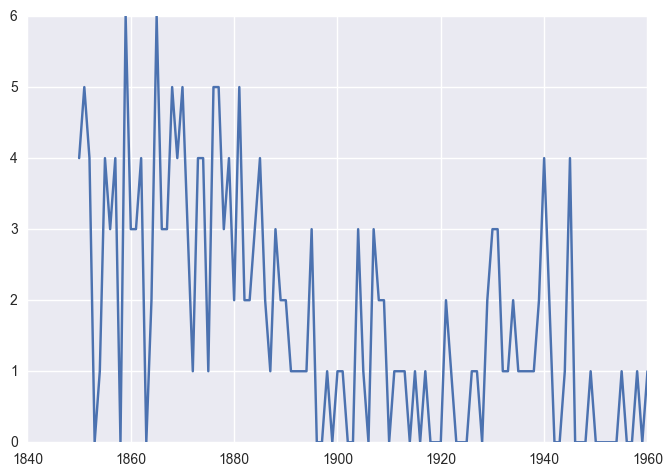

In [2]:
# Disasters/year from 1850-1960
disasters = np.array([4, 5, 4, 0, 1, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5,
                      4, 5, 3, 1, 4, 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1,
                      3, 2, 2, 1, 1, 1, 1, 3, 0, 0, 1, 0, 1, 1, 0, 0, 3, 1, 0,
                      3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 2, 1, 0, 0, 0,
                      1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 4, 2, 0, 0, 1,
                      4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1])
N = len(disasters)
t = np.arange(1850, 1850 + N)
# Generate random test data for comparison
#disasters = np.random.poisson(size=N, lam=2.)
plt.plot(t, disasters);

In [3]:
with pm.Model() as model:
    # Specify priors for tau, mu_1, mu_2
    tau = pm.DiscreteUniform('tau', lower=t.min(), upper=t.max())
    mu = pm.Exponential('mu', lam=np.array([1., 1.]), shape=2)

    # Poisson likelihood function for observed data
    mu_1_or_2 = pm.Deterministic('mu_1_or_2', pm.math.switch(t < tau, mu[0], mu[1]))
    D = pm.Poisson('D', mu_1_or_2, observed=disasters)

Applied log-transform to mu and added transformed mu_log_ to model.


In [4]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, njobs=1)
    
burned_in = trace[5000:]
thinned = burned_in[::10]

100%|██████████| 10000/10000 [00:03<00:00, 2538.06it/s]


## Analyzing the posterior
We can get an idea of the behavior of our Markov chain by viewing the trace of one of the variables:

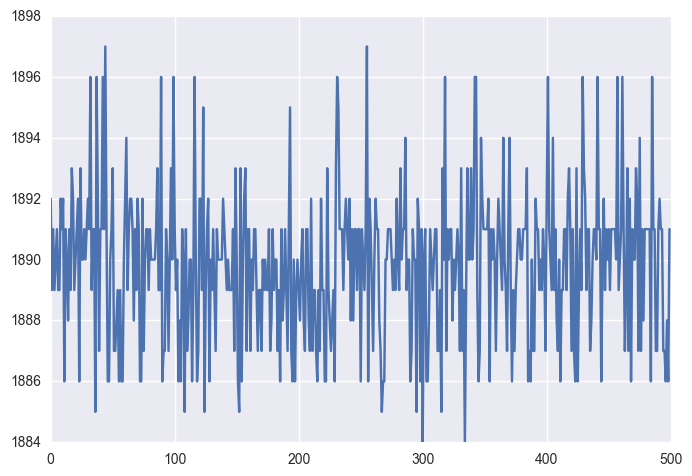

In [5]:
plt.plot(thinned['tau']);

`pymc3` also has its own built-in plotting functionality which helps quickly visualize the distribution of the variables of interest:

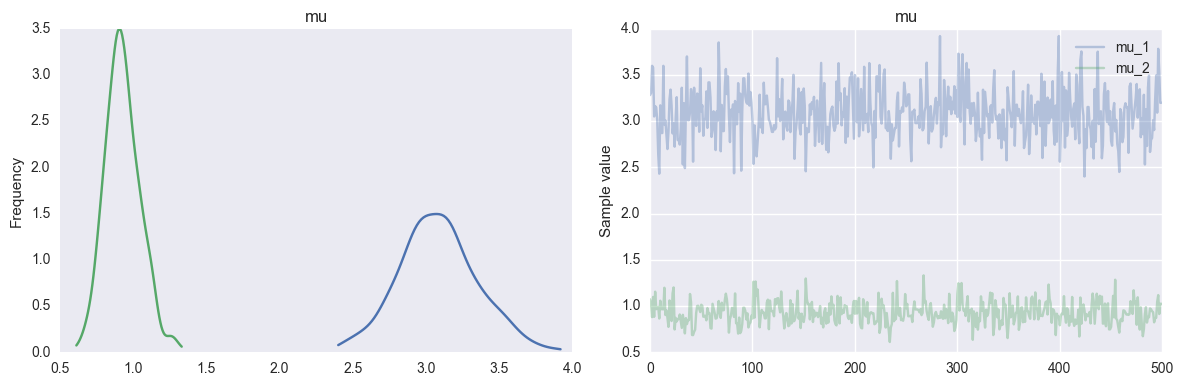

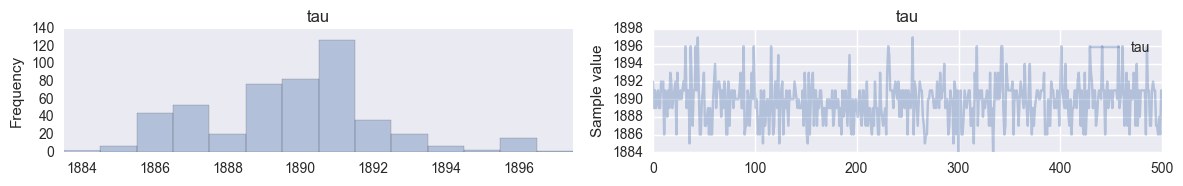

In [6]:
# Variable trace summary plots
pm.plots.traceplot(trace=thinned, varnames=['mu'], figsize=(12, 4));
plt.legend(['mu_1', 'mu_2'])

pm.plots.traceplot(trace=thinned, varnames=['tau']);
plt.legend(['tau'])

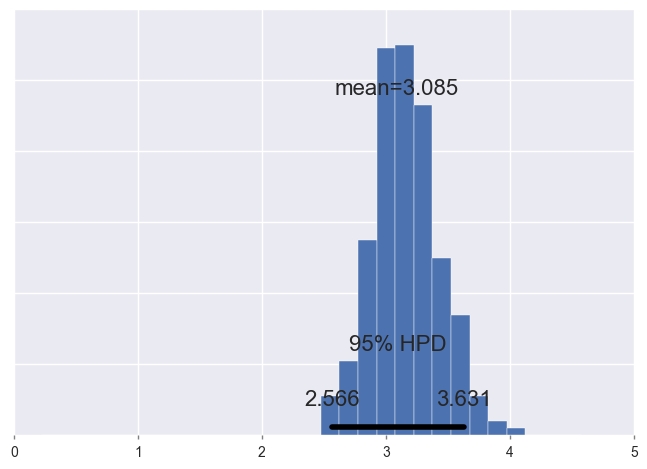

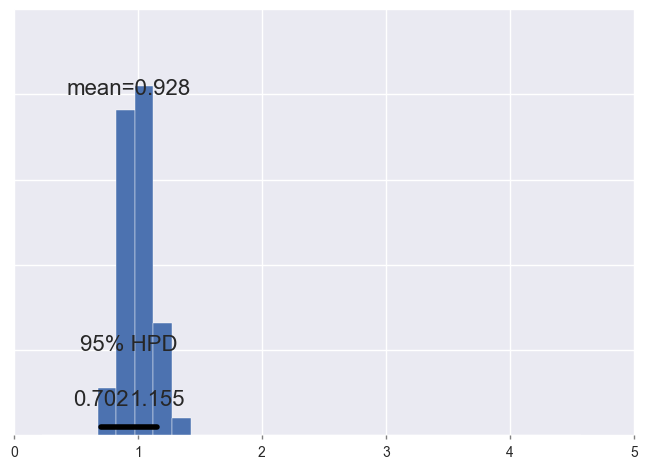

In [7]:
# Detailed posterior distribution plots
pm.plots.plot_posterior(trace=thinned['mu'][:, 0], range=(0.0, 4.5));
pm.plots.plot_posterior(trace=thinned['mu'][:, 1], range=(0.0, 4.5));

Autocorrelation plots give a rough idea of how close to i.i.d the samples from our posterior distribution are:

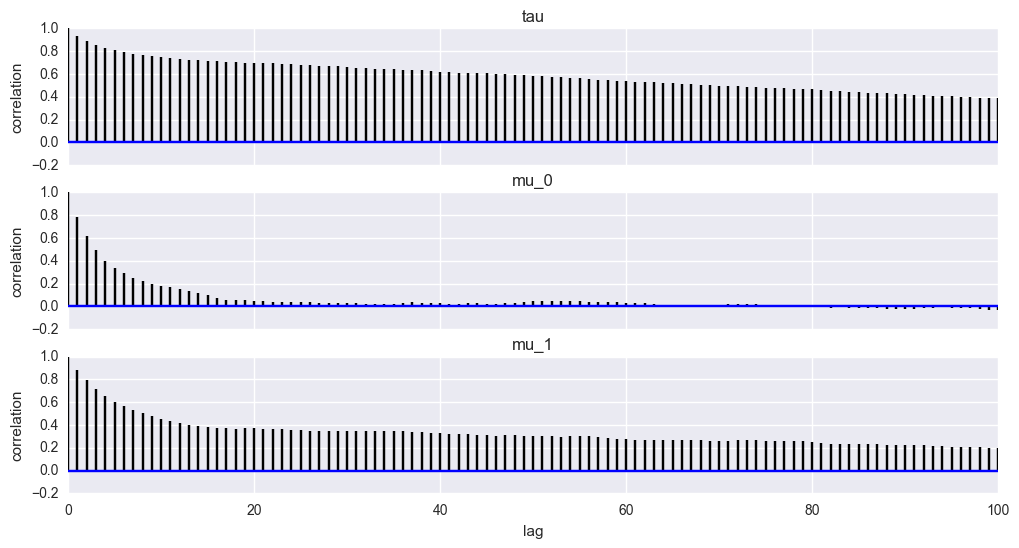

In [8]:
# Full chain (no burn-in or thinning)
pm.plots.autocorrplot(trace=trace, varnames=['tau', 'mu']);

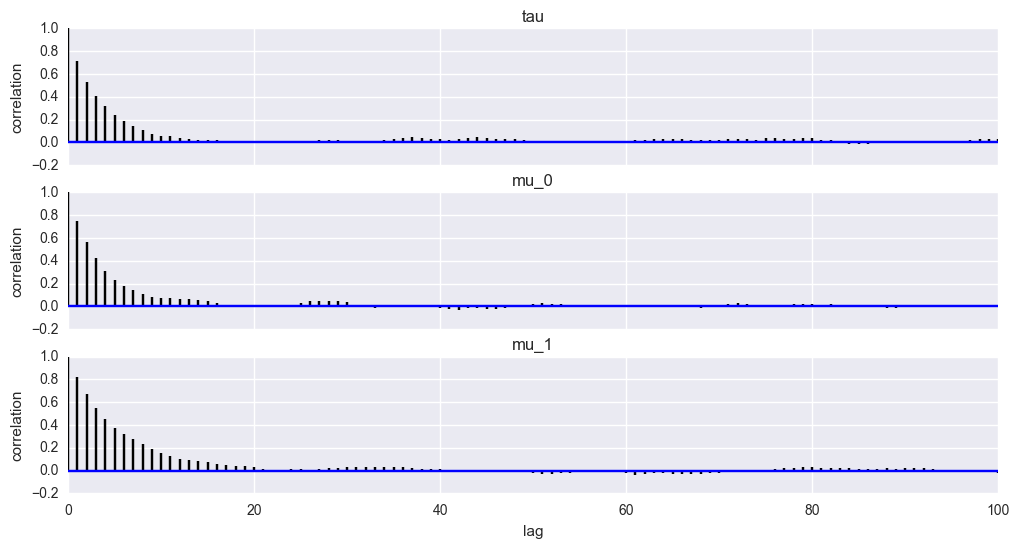

In [9]:
# Chain with 5000 burn-in iterations
pm.plots.autocorrplot(trace=burned_in, varnames=['tau', 'mu']);

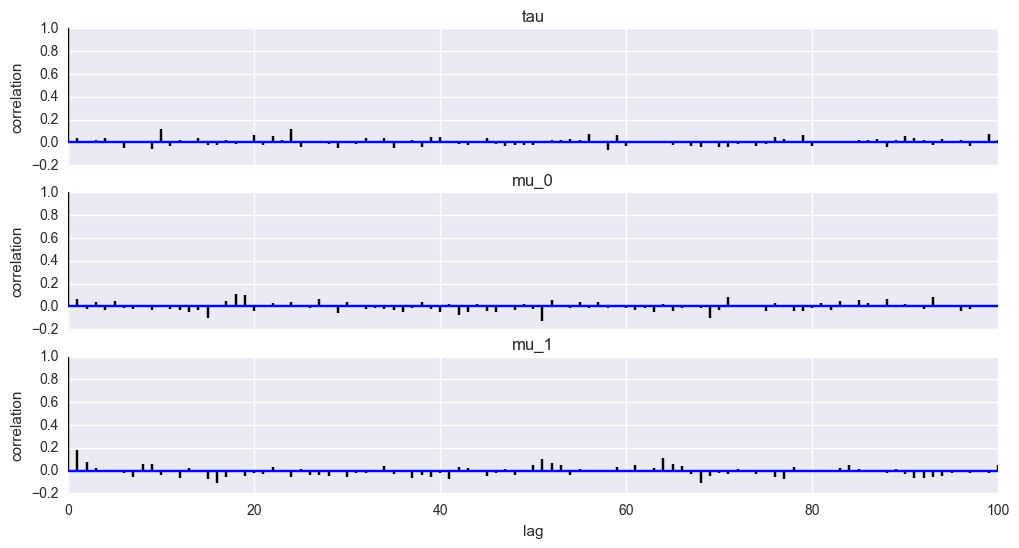

In [10]:
# Chain with 5000 burn-in iterations, thinned by 10x
pm.plots.autocorrplot(trace=thinned, varnames=['tau', 'mu']);

We can also make inferences about the values of other functions/transformations of the parameters:

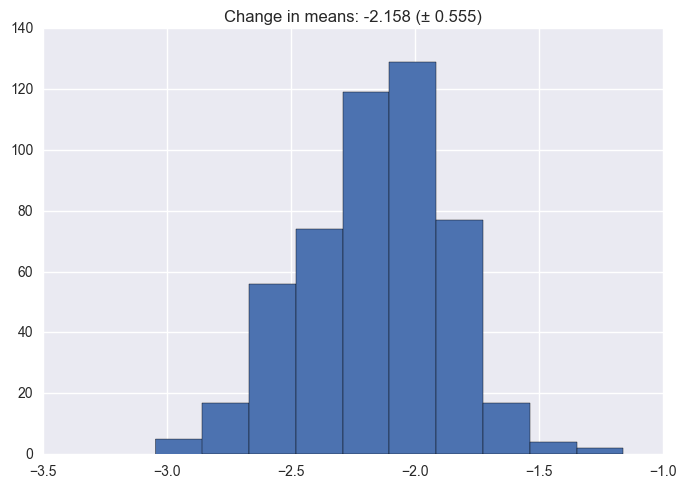

In [11]:
# Posterior distribution of change in mean (mu_2 - mu_1)
change = thinned['mu'][:, 1] - thinned['mu'][:, 0]
ci = np.floor(0.975 * len(change))
plt.hist(change);
plt.title('Change in means: {:1.3f} (± {:1.3f})'.format(
          np.mean(change), np.abs(np.percentile(change, 2.5) - np.percentile(change, 97.5)) / 2));

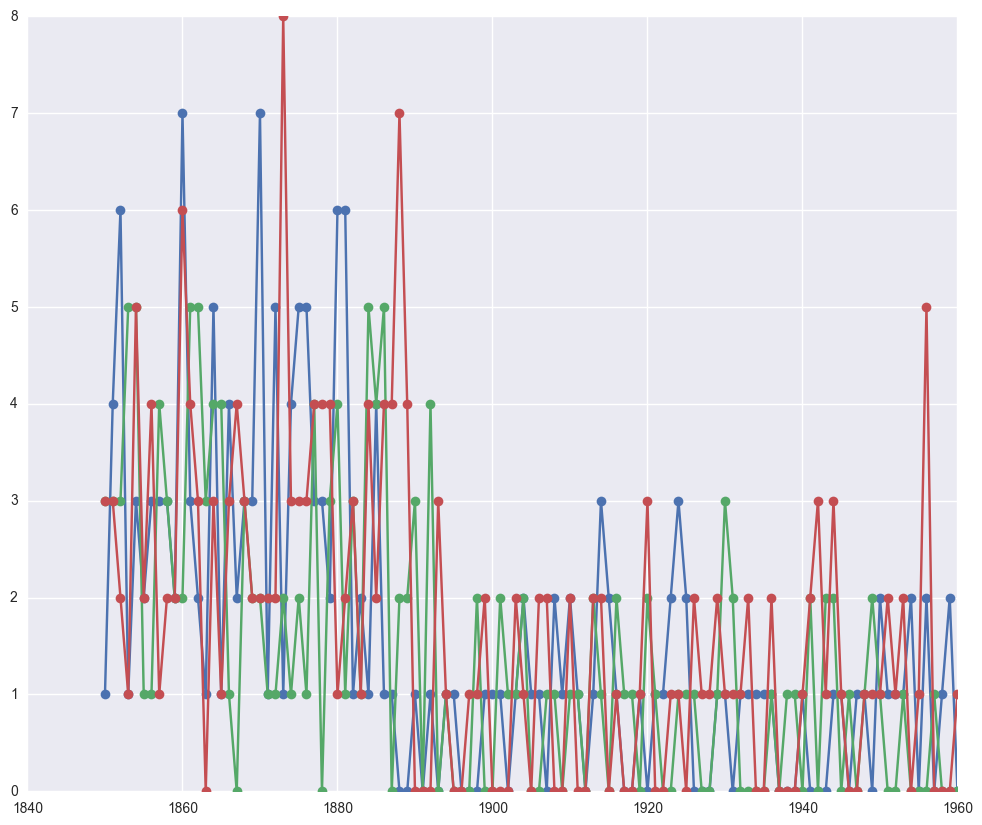

In [12]:
# and we can also plot realizations of the model from the posterior!
plt.figure(figsize=(12, 10))
realizations = pm.sample_ppc(trace, model=model, samples=3)
for D_i in realizations['D']:
    plt.plot(t, D_i, '-o')

## Convergence Diagnostics

Several metrics of convergence are available in `pm.diagnostics`, e.g.:
- Geweke score: compares mean of beginning of chain with mean of end
- Gelman-Rubin: compare variance between chains to variance of single chain

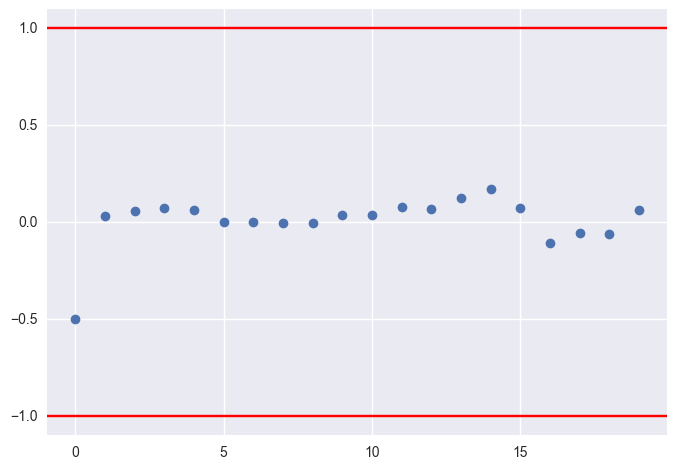

In [13]:
# Plot Geweke score for tau: should lie between -1 and 1
plt.plot(pm.geweke(trace['tau'])[:, 1], 'o')
plt.axhline(1, c='red')
plt.axhline(-1, c='red')
plt.gca().margins(0.05)